# 基于mindspore实现二维线性回归

我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

本文档参考自：https://zh.d2l.ai/chapter_linear-networks/linear-regression-scratch.html

In [1]:
%matplotlib inline
import random
import mindspore
import mindspore.numpy as mnp
import mindspore.ops as ops
from matplotlib import pyplot as plt
from mindspore import Tensor

In [2]:
import sys
sys.path.append('..')

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [3]:
def synthetic_data(w, b, num_examples):  
    """生成 y = Xw + b + 噪声。"""
    print((num_examples, len(w)))
    X = ops.normal((num_examples, len(w)), Tensor(0, mindspore.int32), Tensor(1, mindspore.int32), seed=1)
    y = ops.matmul(X, w) + b
    y += ops.normal(y.shape, Tensor(0, mindspore.int32), Tensor(0.01, mindspore.float32), seed=1)
    return X, y.reshape((-1, 1))

true_w = Tensor([2, -3.4], mindspore.float32)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

(1000, 2)


[WARNING] DEVICE(69226,ffffafacd780,python):2022-11-17-22:01:46.043.800 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/StandardNormal-op0] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(69226,ffffafacd780,python):2022-11-17-22:01:52.113.209 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/StandardNormal-op6] don't support int64, reduce precision from int64 to int32.


`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一维标签值（一个标量）

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: [ 0.30639967 -0.42438635] 
label: [6.2373576]


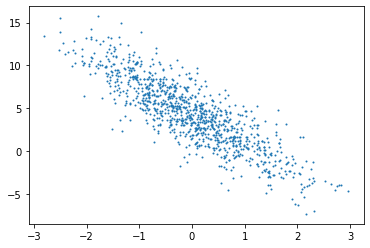

In [5]:
plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = Tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 2.081384   -0.4022577 ]
 [-0.65269184 -0.11089539]
 [ 0.53033173 -0.5723881 ]
 [ 1.0256927  -1.2182392 ]
 [-0.87549025  1.5291665 ]
 [-2.343595   -2.0409315 ]
 [ 0.742893   -0.19725992]
 [ 0.19161588  0.16736197]
 [-0.4255054  -0.38351473]
 [-0.5282511  -2.4119651 ]] 
 [[ 9.723172 ]
 [ 3.2676687]
 [ 7.186453 ]
 [10.389597 ]
 [-2.7376797]
 [ 6.4470363]
 [ 6.345156 ]
 [ 4.012104 ]
 [ 4.646039 ]
 [11.339476 ]]


在我们开始用小批量随机梯度下降优化我们的模型参数之前，需要说明一下MindSpore的设计理念。MindSpore的静态图思路是将整个模型视作一个完整的计算图，即模型、Loss、优化器均需要作为计算图的一部分。这与Pytorch的使用习惯有些不符。接下来将通过线性回归的例子来体现：

In [7]:
import mindspore.nn as nn
from mindspore import Parameter
from mindspore.common.initializer import initializer, Zero, Normal

def linreg(x, w, b):
    return ops.matmul(x, w) + b

定义损失函数。损失函数也需要定义为`nn.Cell`的子类

In [8]:
def squared_loss(y_hat, y):  
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法
这里我们介绍小批量随机梯度下降

In [9]:
class SGD(nn.Cell):
    def __init__(self, lr, batch_size, params):
        super().__init__()
        self.lr = lr
        self.batch_size = batch_size
        self.params = params
        
    def construct(self, grads):
        for idx in range(len(self.params)):
            ops.assign(self.params[idx], self.params[idx] - self.lr * grads[idx] / self.batch_size)
            # 这里用到了一个assign算子，因为静态图里无法直接使用x = x + y来更新权重，采用assign算子实际上是为了
            # 能够给权重赋值，覆盖旧的权重数据
        return True

按照上面的叙述，需要讲network和loss连接

定义模型，定义模型的参数，模型的输入输出。这里需要用到`nn.Cell`，因为只有这样才能够使编译器识别编译为计算图。

In [10]:
class Net(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(initializer(Normal(0.01, 0), (2, 1), mindspore.float32))
        self.b = Parameter(initializer(Zero(), 1, mindspore.float32))
        
    def construct(self, x, y):
        y_hat = linreg(x, self.w, self.b)
        loss = squared_loss(y_hat, y)
        return loss

训练过程。其实包括三步，分别为：

1. 计算正向结果
2. 计算反向梯度
3. 更新权重

按照上面的叙述，需要将network、loss、optimizer连接，作为一个完整的计算图。因此也要继承`nn.Cell`

In [11]:
class Train(nn.Cell):
    def __init__(self, network, optimizer):
        super().__init__()
        self.network = network
        self.optimizer = optimizer
        self.grad = ops.GradOperation(get_by_list=True)
        
    def construct(self, x, y):
        loss = self.network(x, y)
        grads = self.grad(self.network, self.optimizer.params)(x, y)
        loss = ops.depend(loss, self.optimizer(grads))
        return loss

In [12]:
lr = 0.03
num_epochs = 3
net = Net()
optim = SGD(lr, batch_size, net.trainable_params())
train = Train(net, optim)

In [13]:
for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):
        l = train(x, y)
    train_l = net(features, labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean().asnumpy()):f}')

epoch 1, loss 0.029778
epoch 2, loss 0.000103
epoch 3, loss 0.000049


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [14]:
print(f'w的估计误差: {true_w - net.trainable_params()[0].reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - net.trainable_params()[1]}')

w的估计误差: [ 4.6968460e-05 -1.2917519e-03]
b的估计误差: [0.00015879]
